# BERT4Rec-based recommendation system

In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertModel, BertConfig
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Ensure compatibility with Jupyter Notebook
%matplotlib inline

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [91]:
# Function to load the MovieLens dataset
def load_data(filepath="ml-1m/ratings.dat"):
    df = pd.read_csv(filepath, sep="::", engine="python", 
                     names=["userId", "movieId", "rating", "timestamp"])
    df = df.sort_values(by=["userId", "timestamp"])  # Sort by user and timestamp
    user_movie_dict = df.groupby("userId")[["movieId", "rating"]].apply(lambda x: list(zip(x["movieId"], x["rating"]))).to_dict()
    return user_movie_dict

# Load dataset
user_movie_dict = load_data()
print(f"Loaded {len(user_movie_dict)} users' movie interaction sequences")

# Print a sample of user-movie interactions for debugging
for user, movies in list(user_movie_dict.items())[:3]:
    print(f"User {user}: {movies}")

Loaded 6040 users' movie interaction sequences
User 1: [(3186, 4), (1270, 5), (1721, 4), (1022, 5), (2340, 3), (1836, 5), (3408, 4), (2804, 5), (1207, 4), (1193, 5), (720, 3), (260, 4), (919, 4), (608, 4), (2692, 4), (1961, 5), (2028, 5), (3105, 5), (938, 4), (1035, 5), (1962, 4), (2018, 4), (150, 5), (1028, 5), (1097, 4), (914, 3), (1287, 5), (2797, 4), (2762, 4), (1246, 4), (661, 3), (2918, 4), (531, 4), (3114, 4), (2791, 4), (2321, 3), (1029, 5), (1197, 3), (594, 4), (2398, 4), (1545, 4), (527, 5), (595, 5), (2687, 3), (745, 3), (588, 4), (1, 5), (2355, 5), (2294, 4), (783, 4), (1566, 4), (1907, 4), (48, 5)]
User 2: [(1198, 4), (1210, 4), (1217, 3), (2717, 3), (1293, 5), (2943, 4), (1225, 5), (1193, 5), (318, 5), (3030, 4), (2858, 4), (1213, 2), (1945, 5), (1207, 4), (593, 5), (3095, 4), (3468, 5), (1873, 4), (515, 5), (1090, 2), (2501, 5), (3035, 4), (110, 5), (2067, 5), (3147, 5), (1247, 5), (3105, 4), (1357, 5), (1196, 5), (1957, 5), (1953, 4), (920, 5), (1834, 4), (1084, 3), (19

In [112]:
def split_train_test(user_movie_dict, test_ratio=0.2, min_interactions=5):
    train_dict, test_dict = {}, {}

    for user, movies in user_movie_dict.items():
        if len(movies) >= min_interactions:  # Only split users with enough data
            split_idx = int(len(movies) * (1 - test_ratio))

            # Ensure there's at least one test item
            if split_idx >= len(movies):  
                split_idx = len(movies) - 1

            train_dict[user] = movies[:split_idx]
            test_dict[user] = movies[split_idx:]

        else:
            train_dict[user] = movies  # Assign all to train if not enough interactions
            test_dict[user] = []  # Keep test empty for these users

    # Remove users with empty test sets
    test_dict = {user: movies for user, movies in test_dict.items() if movies}

    return train_dict, test_dict

# Apply the fixed train-test split
train_dict, test_dict = split_train_test(user_movie_dict, test_ratio=0.2, min_interactions=5)

# Print updated counts
print(f"Train users: {len(train_dict)}, Test users: {len(test_dict)}")

# Check if any users still have the same train and test sets
overlap_count = sum(1 for user in train_dict if train_dict[user] == test_dict.get(user, []))
print(f"Users with identical train and test sets: {overlap_count}")


Train users: 6040, Test users: 6040
Users with identical train and test sets: 0


In [113]:
class MovieDataset(Dataset):
    def __init__(self, user_movie_dict, max_len=50):
        self.users = list(user_movie_dict.keys())
        self.sequences = [user_movie_dict[user] for user in self.users]
        self.max_len = max_len

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]

        # Separate movie IDs and ratings
        movie_ids = [pair[0] for pair in sequence]
        ratings = [pair[1] for pair in sequence]

        # Pad or truncate sequences
        input_ids = movie_ids[:self.max_len] + [0] * (self.max_len - len(movie_ids))
        rating_ids = ratings[:self.max_len] + [0] * (self.max_len - len(ratings))

        target_ids = input_ids[1:] + [0]  # Next-movie prediction
        attention_mask = [1 if id != 0 else 0 for id in input_ids]  # Attention mask

        return (
            torch.tensor(input_ids), 
            torch.tensor(rating_ids), 
            torch.tensor(target_ids), 
            torch.tensor(attention_mask)
        )

# Create Train and Test Dataset & DataLoader
train_dataset = MovieDataset(train_dict, max_len=30)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = MovieDataset(test_dict, max_len=30)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [114]:
#switch to 64

In [115]:
class BERT4Rec(nn.Module):
    def __init__(self, vocab_size, rating_size=6, hidden_size=256, num_layers=4, num_heads=4, max_len=30):
        super(BERT4Rec, self).__init__()

        config = BertConfig(
            vocab_size=vocab_size,
            hidden_size=hidden_size,
            num_attention_heads=num_heads,
            num_hidden_layers=num_layers,
            max_position_embeddings=max_len,
        )

        self.bert = BertModel(config)
        
        self.rating_embedding = nn.Embedding(rating_size, hidden_size)

        self.output_layer = nn.Linear(hidden_size, vocab_size)
    def get_causal_mask(self, seq_len, device):
    # Lower triangular matrix (causal mask)
        causal_mask = torch.tril(torch.ones((seq_len, seq_len), dtype=torch.bool, device=device))
        return causal_mask.unsqueeze(0)  # (1, seq_len, seq_len) for broadcasting
    
    def forward(self, input_ids, rating_ids, attention_mask):
        batch_size, seq_len = input_ids.shape
        causal_mask = self.get_causal_mask(seq_len, input_ids.device)
        extended_attention_mask = causal_mask.float().masked_fill(causal_mask == 0, float('-inf'))
        extended_attention_mask = attention_mask.unsqueeze(1) * causal_mask  
        movie_emb = self.bert(input_ids=input_ids, attention_mask=extended_attention_mask).last_hidden_state
        rating_emb = self.rating_embedding(rating_ids)

        combined_emb = movie_emb + rating_emb

        return self.output_layer(combined_emb)

vocab_size = max(max(seq)[0] for seq in user_movie_dict.values()) + 1
model = BERT4Rec(vocab_size, rating_size=6).to(device)

print(f"Initialized BERT4Rec model with vocab size {vocab_size} and rating embedding")


Initialized BERT4Rec model with vocab size 3953 and rating embedding


In [116]:
def train_model(model, dataloader, epochs=100, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        for inputs, ratings, targets, attention_mask in dataloader:
            inputs, ratings, targets, attention_mask = (
                inputs.to(device), ratings.to(device), targets.to(device), attention_mask.to(device)
            )

            optimizer.zero_grad()
            outputs = model(inputs, ratings, attention_mask)
            loss = criterion(outputs.view(-1, outputs.shape[-1]), targets.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch {epoch + 1}, Train Loss: {total_loss / len(dataloader)}")

# Train Model
train_model(model, train_dataloader)


Epoch 1, Train Loss: 6.234511656510202
Epoch 2, Train Loss: 5.258815198195608
Epoch 3, Train Loss: 4.864292857521459
Epoch 4, Train Loss: 4.609587543889096
Epoch 5, Train Loss: 4.383400357396979
Epoch 6, Train Loss: 4.1633301483957394
Epoch 7, Train Loss: 3.9329417680439196
Epoch 8, Train Loss: 3.670286095769782
Epoch 9, Train Loss: 3.374976002542596
Epoch 10, Train Loss: 3.0657153631511487
Epoch 11, Train Loss: 2.745516922599391
Epoch 12, Train Loss: 2.4262656663593494
Epoch 13, Train Loss: 2.1250843826093173
Epoch 14, Train Loss: 1.8393210774973818
Epoch 15, Train Loss: 1.6001582045304148
Epoch 16, Train Loss: 1.4018467263171548
Epoch 17, Train Loss: 1.2390326637970774
Epoch 18, Train Loss: 1.0965778187701576
Epoch 19, Train Loss: 0.9892310086049532
Epoch 20, Train Loss: 0.900680737118972
Epoch 21, Train Loss: 0.8237323390810113
Epoch 22, Train Loss: 0.7615593082026432
Epoch 23, Train Loss: 0.7218807552990161
Epoch 24, Train Loss: 0.690897325151845
Epoch 25, Train Loss: 0.65139966230

In [117]:
def evaluate_model(model, dataloader, k=10):
    model.eval()
    total_loss = 0
    total_recall = 0
    total_ndcg = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, ratings, targets, attention_mask in dataloader:
            inputs, ratings, targets, attention_mask = (
                inputs.to(device), ratings.to(device), targets.to(device), attention_mask.to(device)
            )

            outputs = model(inputs, ratings, attention_mask)  # (batch_size, seq_len, vocab_size)
            loss = criterion(outputs.view(-1, outputs.shape[-1]), targets.view(-1))
            total_loss += loss.item()

            _, top_k_predictions = torch.topk(outputs, k, dim=-1)
            recall = recall_at_k(top_k_predictions, targets, k)
            ndcg = ndcg_at_k(top_k_predictions, targets, k)

            total_recall += recall
            total_ndcg += ndcg

    avg_loss = total_loss / len(dataloader)
    avg_recall = total_recall / len(dataloader)
    avg_ndcg = total_ndcg / len(dataloader)

    print(f"Test Loss: {avg_loss:.4f}, Recall@{k}: {avg_recall:.4f}, NDCG@{k}: {avg_ndcg:.4f}")
    return avg_loss, avg_recall, avg_ndcg

# Compute Recall@K
def recall_at_k(top_k_predictions, targets, k):
    hits = (top_k_predictions == targets.unsqueeze(-1)).float()  # Check if target is in top K
    recall = hits.sum(dim=-1).mean().item()  # Compute recall
    return recall

# Compute NDCG@K
def ndcg_at_k(top_k_predictions, targets, k):
    hits = (top_k_predictions == targets.unsqueeze(-1)).float()
    log_positions = 1 / torch.log2(torch.arange(2, k + 2, device=targets.device).float())  # Discount factor
    dcg = (hits * log_positions).sum(dim=-1).mean().item()
    return dcg

In [118]:
# Evaluate on Test DataLoader
test_loss, recall_k, ndcg_k = evaluate_model(model, test_dataloader, k=10)

Test Loss: 10.5603, Recall@10: 0.4076, NDCG@10: 0.3916


In [152]:
base_loss = [
    6.234511656510202, 5.258815198195608, 4.864292857521459, 4.609587543889096, 4.383400357396979,
    4.1633301483957394, 3.9329417680439196, 3.670286095769782, 3.374976002542596, 3.0657153631511487,
    2.745516922599391, 2.4262656663593494, 2.1250843826093173, 1.8393210774973818, 1.6001582045304148,
    1.4018467263171548, 1.2390326637970774, 1.0965778187701576, 0.9892310086049532, 0.900680737118972,
    0.8237323390810113, 0.7615593082026432, 0.7218807552990161, 0.690897325151845, 0.6513996623064342,
    0.6330185369441383, 0.6103868158240068, 0.5899869843533164, 0.5734426473316393, 0.562607489134136,
    0.5477919173868079, 0.5451329623398028, 0.533745390176773, 0.5223218136712124, 0.5129173573694731,
    0.5111136913299561, 0.5086631583540063, 0.5068886797679099, 0.49954405866171187, 0.4943481417078721,
    0.48398167961522154, 0.47207374666866503, 0.4790943603766592, 0.4700188031322078, 0.46434882910628067,
    0.4630568764711681, 0.4573816428059026, 0.4557538418393386, 0.45316164556302524, 0.4514904398667185,
    0.4464720907964205, 0.44737485176638553, 0.4465474994559037, 0.4448343270703366, 0.4387681518730364,
    0.4305760418113909, 0.4297540551737735, 0.4234028195080004, 0.4316981249733975, 0.4275556633346959,
    0.4269647676693766, 0.4155218428687045, 0.40496373490283366, 0.411747722249282, 0.4101536208077481,
    0.4110331218493612, 0.40770320359029266, 0.40398395814393695, 0.41419766921746104, 0.4067469596862793,
    0.39907399070890326, 0.39921768056718926, 0.3997115533602865, 0.39560195772271406, 0.3909385028638338,
    0.3894152569143396, 0.38653726483646195, 0.3896264054273304, 0.3859038538054416, 0.3838778178942831,
    0.38457447698241787, 0.38714024581407247, 0.38636196945842943, 0.3825875382674368, 0.37978118030648483,
    0.3839054741357502, 0.37453531873853585, 0.3737956094114404, 0.3661703966165844, 0.3645727035246397,
    0.36652323258550545, 0.36597087383270266, 0.37074263440935235, 0.3739123203252491, 0.3668940785684084,
    0.3655358430586363, 0.36421462360181306, 0.3672918627136632, 0.3654866839710035, 0.3611119747161865
]
subset_loss = [
    3.3147300946085076, 2.8067441714437384, 2.649940884740729, 2.520018306531404, 2.3771959179326108,
    2.236528471896523, 2.0852128204546476, 1.9376452584015695, 1.7870519939221834, 1.6524019918943706,
    1.5192723449907806, 1.4038760022113197, 1.3011176749279625, 1.1969592408130043, 1.1112050232134367,
    1.034997430600618, 0.9636074436338324, 0.9027518880994696, 0.8540292118725024, 0.80158758665386,
    0.7638526395747536, 0.7281109778504623, 0.6943994697771574, 0.6669233736238982, 0.646339541987369,
    0.628032492336474, 0.608039369081196, 0.5862240091750496, 0.5664565312234979, 0.5539663214432565,
    0.5386180877685547, 0.5339807858592586, 0.5206379143815292, 0.5098352432250977, 0.5002810826427058,
    0.4949310418806578, 0.4863194879732634, 0.4841578809838546, 0.4805969112797787, 0.46406832682458976,
    0.45715284378905047, 0.4577021190994664, 0.4559803335290206, 0.4501081855673539, 0.4418792429723238,
    0.44036914267038046, 0.43489834227060015, 0.4328285408647437, 0.4289426314203363, 0.431137290126399,
    0.4223352457347669, 0.41803906528573287, 0.41337860289372896, 0.41440639684074804, 0.41052225451720387,
    0.40919541622463024, 0.40803984780060615, 0.4061470737582759, 0.40109252835574905, 0.400395384274031,
    0.3914928382948825, 0.39695488590943184, 0.3963962495326996, 0.3913707457090679, 0.3870519223966097,
    0.3847171193674991, 0.3837308030379446, 0.38222803912664716, 0.38406436757037515, 0.3829567241041284,
    0.3798058453359102, 0.3761625725972025, 0.37745859811180515, 0.37603871508648523, 0.371460664586017,
    0.3752833949892144, 0.3683257526472995, 0.36562813112610265, 0.36548810318896646, 0.36983035959695515,
    0.3646730840206146, 0.3654382103367856, 0.3612338687244214, 0.36166387012130335, 0.35728011382253544,
    0.3562621047622279, 0.3578685114258214, 0.35769517766801934, 0.3550887452928643, 0.35280719650419134,
    0.34690672692499663, 0.3520342171192169, 0.3459433750102395, 0.34808150059298465, 0.3452917020571859,
    0.3483976379821175, 0.34701430954431234, 0.34574031359271, 0.3434565917441719, 0.34545032507494877
]

In [163]:
min(subset_loss)

0.3434565917441719

In [139]:
from collections import defaultdict

In [140]:
movie_frequency = defaultdict(int)

In [141]:
for x in user_movie_dict:
    for movie in user_movie_dict[x]:
        movie_frequency[movie[0]] += 1

In [142]:
sorted_d = defaultdict(int, dict(sorted(movie_frequency.items(), key=lambda item: item[1], reverse=True)))

In [143]:
subset = list(sorted_d.keys())[207:]

In [154]:
sorted_d

defaultdict(int,
            {2858: 3428,
             260: 2991,
             1196: 2990,
             1210: 2883,
             480: 2672,
             2028: 2653,
             589: 2649,
             2571: 2590,
             1270: 2583,
             593: 2578,
             1580: 2538,
             1198: 2514,
             608: 2513,
             2762: 2459,
             110: 2443,
             2396: 2369,
             1197: 2318,
             527: 2304,
             1617: 2288,
             1265: 2278,
             1097: 2269,
             2628: 2250,
             2997: 2241,
             318: 2227,
             858: 2223,
             356: 2194,
             2716: 2181,
             296: 2171,
             1240: 2098,
             1: 2077,
             1214: 2024,
             2916: 1996,
             457: 1995,
             3578: 1924,
             1200: 1820,
             541: 1800,
             2987: 1799,
             1259: 1785,
             50: 1783,
             34: 1751,
   

In [165]:
len(sorted_d)

3706

In [157]:
df = pd.read_csv("ml-1m/ratings.dat", sep="::", engine="python", 
                     names=["userId", "movieId", "rating", "timestamp"])

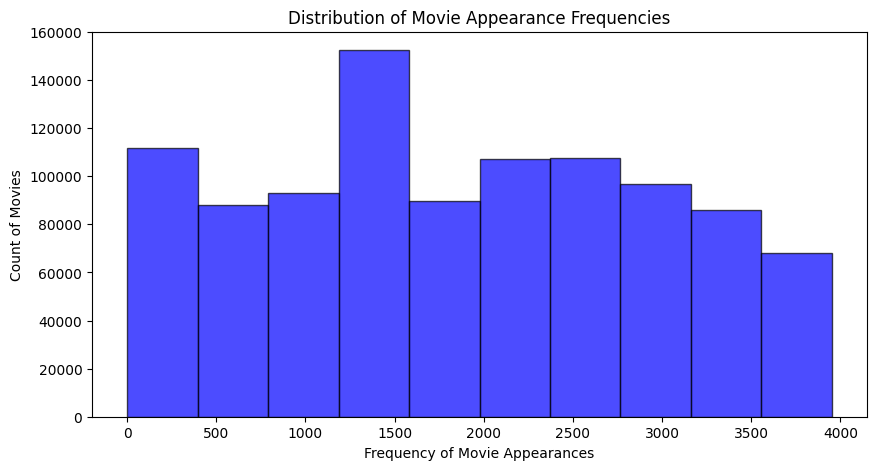

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.hist(sorted_d.values(), bins=10, color='blue', alpha=0.7, edgecolor='black')

plt.xlabel('Frequency of Movie Appearances')
plt.ylabel('Count of Movies')
plt.title('Distribution of Movie Appearance Frequencies')

plt.show()

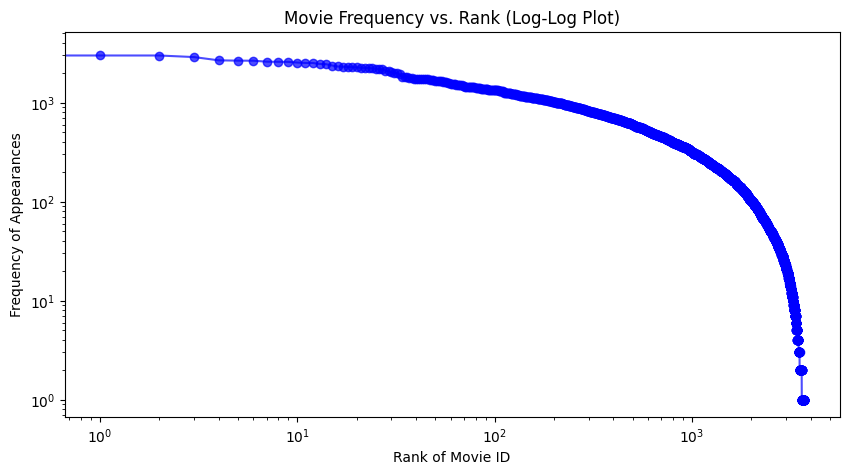

In [160]:
# Sort movie counts in descending order
sorted_frequencies = sorted(sorted_d.values(), reverse=True)

# Plot rank vs frequency
plt.figure(figsize=(10, 5))
plt.plot(sorted_frequencies, marker='o', linestyle='-', color='blue', alpha=0.7)

plt.xscale('log')  # Log scale for better visibility
plt.yscale('log')  # Log scale to capture extreme values
plt.xlabel('Rank of Movie ID')
plt.ylabel('Frequency of Appearances')
plt.title('Movie Frequency vs. Rank (Log-Log Plot)')

plt.show()


In [144]:
# Function to load the MovieLens dataset
def load_data(filepath="ml-1m/ratings.dat"):
    df = pd.read_csv(filepath, sep="::", engine="python", 
                     names=["userId", "movieId", "rating", "timestamp"])
    df = df[~df.movieId.isin(subset)]
    df = df.sort_values(by=["userId", "timestamp"])  # Sort by user and timestamp
    user_movie_dict = df.groupby("userId")[["movieId", "rating"]].apply(lambda x: list(zip(x["movieId"], x["rating"]))).to_dict()
    return user_movie_dict

# Load dataset
user_movie_dict = load_data()
print(f"Loaded {len(user_movie_dict)} users' movie interaction sequences")

# Print a sample of user-movie interactions for debugging
for user, movies in list(user_movie_dict.items())[:3]:
    print(f"User {user}: {movies}")

Loaded 6039 users' movie interaction sequences
User 1: [(1270, 5), (1721, 4), (3408, 4), (2804, 5), (1193, 5), (260, 4), (919, 4), (608, 4), (2692, 4), (1961, 5), (2028, 5), (150, 5), (1028, 5), (1097, 4), (2797, 4), (2762, 4), (2918, 4), (3114, 4), (2791, 4), (2321, 3), (1197, 3), (527, 5), (595, 5), (588, 4), (1, 5), (2355, 5)]
User 2: [(1198, 4), (1210, 4), (1225, 5), (1193, 5), (318, 5), (2858, 4), (1213, 2), (593, 5), (1090, 2), (110, 5), (3147, 5), (1247, 5), (1196, 5), (920, 5), (3471, 5), (1259, 5), (1954, 5), (1784, 5), (1968, 2), (3578, 5), (590, 5), (2194, 4), (2268, 5), (3255, 4), (2396, 4), (2321, 3), (356, 5), (1265, 3), (589, 4), (2028, 4), (2571, 4), (457, 4), (2916, 3), (1610, 5), (480, 5), (380, 5), (3418, 4), (3256, 2), (21, 1), (349, 4), (1527, 4), (1370, 5), (648, 4), (1372, 3), (780, 3), (2628, 3), (736, 4), (1544, 4), (1917, 3)]
User 3: [(593, 3), (2858, 4), (1968, 4), (1961, 4), (3671, 5), (590, 4), (260, 5), (1196, 4), (1197, 5), (1198, 5), (1210, 4), (1291, 4)

In [145]:
def split_train_test(user_movie_dict, test_ratio=0.2, min_interactions=5):
    train_dict, test_dict = {}, {}

    for user, movies in user_movie_dict.items():
        if len(movies) >= min_interactions:  # Only split users with enough data
            split_idx = int(len(movies) * (1 - test_ratio))

            # Ensure there's at least one test item
            if split_idx >= len(movies):  
                split_idx = len(movies) - 1

            train_dict[user] = movies[:split_idx]
            test_dict[user] = movies[split_idx:]

        else:
            train_dict[user] = movies  # Assign all to train if not enough interactions
            test_dict[user] = []  # Keep test empty for these users

    # Remove users with empty test sets
    test_dict = {user: movies for user, movies in test_dict.items() if movies}

    return train_dict, test_dict

# Apply the fixed train-test split
train_dict, test_dict = split_train_test(user_movie_dict, test_ratio=0.2, min_interactions=5)

# Print updated counts
print(f"Train users: {len(train_dict)}, Test users: {len(test_dict)}")

# Check if any users still have the same train and test sets
overlap_count = sum(1 for user in train_dict if train_dict[user] == test_dict.get(user, []))
print(f"Users with identical train and test sets: {overlap_count}")

Train users: 6039, Test users: 5980
Users with identical train and test sets: 0


In [148]:
class MovieDataset(Dataset):
    def __init__(self, user_movie_dict, max_len=50):
        self.users = list(user_movie_dict.keys())
        self.sequences = [user_movie_dict[user] for user in self.users]
        self.max_len = max_len

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]

        # Separate movie IDs and ratings
        movie_ids = [pair[0] for pair in sequence]
        ratings = [pair[1] for pair in sequence]

        # Pad or truncate sequences
        input_ids = movie_ids[:self.max_len] + [0] * (self.max_len - len(movie_ids))
        rating_ids = ratings[:self.max_len] + [0] * (self.max_len - len(ratings))

        target_ids = input_ids[1:] + [0]  # Next-movie prediction
        attention_mask = [1 if id != 0 else 0 for id in input_ids]  # Attention mask

        return (
            torch.tensor(input_ids), 
            torch.tensor(rating_ids), 
            torch.tensor(target_ids), 
            torch.tensor(attention_mask)
        )

# Create Train and Test Dataset & DataLoader
train_dataset = MovieDataset(train_dict, max_len=30)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = MovieDataset(test_dict, max_len=30)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [149]:
def train_model(model, dataloader, epochs=100, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        for inputs, ratings, targets, attention_mask in dataloader:
            inputs, ratings, targets, attention_mask = (
                inputs.to(device), ratings.to(device), targets.to(device), attention_mask.to(device)
            )

            optimizer.zero_grad()
            outputs = model(inputs, ratings, attention_mask)
            loss = criterion(outputs.view(-1, outputs.shape[-1]), targets.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch {epoch + 1}, Train Loss: {total_loss / len(dataloader)}")

# Train Model
train_model(model, train_dataloader)


Epoch 1, Train Loss: 3.3147300946085076
Epoch 2, Train Loss: 2.8067441714437384
Epoch 3, Train Loss: 2.649940884740729
Epoch 4, Train Loss: 2.520018306531404
Epoch 5, Train Loss: 2.3771959179326108
Epoch 6, Train Loss: 2.236528471896523
Epoch 7, Train Loss: 2.0852128204546476
Epoch 8, Train Loss: 1.9376452584015695
Epoch 9, Train Loss: 1.7870519939221834
Epoch 10, Train Loss: 1.6524019918943706
Epoch 11, Train Loss: 1.5192723449907806
Epoch 12, Train Loss: 1.4038760022113197
Epoch 13, Train Loss: 1.3011176749279625
Epoch 14, Train Loss: 1.1969592408130043
Epoch 15, Train Loss: 1.1112050232134367
Epoch 16, Train Loss: 1.034997430600618
Epoch 17, Train Loss: 0.9636074436338324
Epoch 18, Train Loss: 0.9027518880994696
Epoch 19, Train Loss: 0.8540292118725024
Epoch 20, Train Loss: 0.80158758665386
Epoch 21, Train Loss: 0.7638526395747536
Epoch 22, Train Loss: 0.7281109778504623
Epoch 23, Train Loss: 0.6943994697771574
Epoch 24, Train Loss: 0.6669233736238982
Epoch 25, Train Loss: 0.6463395

In [150]:
test_loss, recall_k, ndcg_k = evaluate_model(model, test_dataloader, k=10)

Test Loss: 4.1583, Recall@10: 0.7078, NDCG@10: 0.6812


In [89]:
#show loss curves and recall

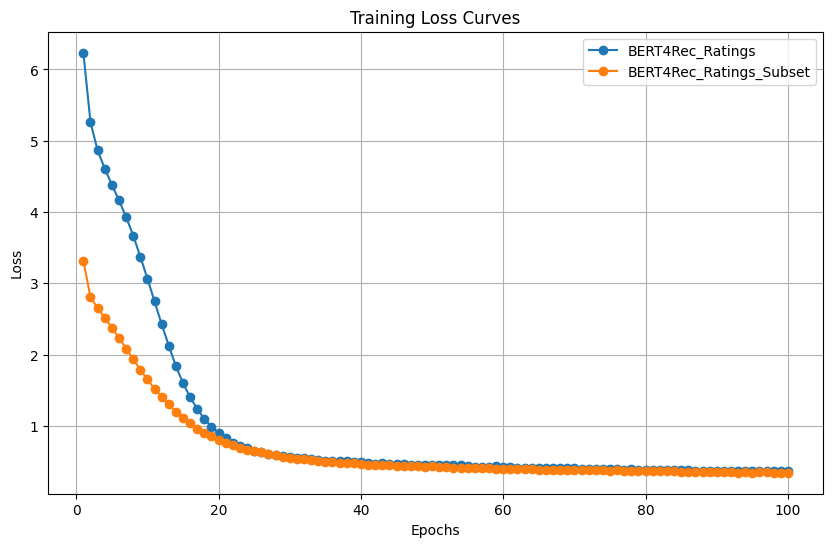

In [153]:
import matplotlib.pyplot as plt

def plot_loss_curves(losses_dict):
    """
    Plots loss curves for multiple models.
    
    Args:
        losses_dict (dict): Dictionary containing model names as keys and lists of loss values as values.
    """
    plt.figure(figsize=(10, 6))
    
    for model_name, losses in losses_dict.items():
        plt.plot(range(1, len(losses) + 1), losses, marker='o', label=model_name)
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with sample data (replace with actual loss values from training)
losses_dict = {
    "BERT4Rec_Ratings": base_loss,
    "BERT4Rec_Ratings_Subset": subset_loss
}

plot_loss_curves(losses_dict)